In [2]:
import sys, os, re
from typing import *
sys.path = (["../src/", "../"] if re.match(r"^(\w\:\\)|(/)", os.getcwd()) else []) + sys.path
import qubx
%qubxd

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.basics import DataType, Instrument, Signal
from qubx.core.interfaces import IStrategy, IStrategyContext, TriggerEvent, MarketEvent
from qubx.core.series import Bar, Quote, Trade
from qubx.data.readers import InMemoryDataFrameReader, DataReader, AsDict, AsTrades, AsOhlcvSeries, AsBars, AsQuotes, AsTimestampedRecords, AsPandasFrame,RestoreTicksFromOHLC, RestoredBarsFromOHLC
from qubx.backtester.utils import _StructureSniffer
from qubx.core.metrics import tearsheet, chart_signals
from qubx.pandaz.utils import *
import qubx.ta.indicators as ta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.data.helpers import loader
from qubx.backtester.simulator import simulate

ld = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


### <s>Current approach </s>

In [6]:
class TestA(IStrategy):
    """ Document your strategy here """
    timeframe: str = "15Min"
    exchange = 'BINANCE.UM'

    def on_init(self, ctx: IStrategyContext):
        ctx.set_base_subscription(DataType.OHLC[self.timeframe])
        ctx.set_event_schedule("55 23 * * *")
        ctx.set_fit_schedule("50 23 * * 1")
        self._idx = 0
        self._to_test = [
            [self.find_instrument(s) for s in ["BTCUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "BCHUSDT", "LTCUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "AAVEUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BCHUSDT"]],
        ]

    def on_fit(self, ctx: IStrategyContext):
        logger.info(f" -> subscribe : {self.lst(self._to_test[self._idx])}")
        ctx.set_universe(self._to_test[self._idx])
        self._idx += 1
        if self._idx >= len(self._to_test):
            self._idx = 0 

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> Optional[List[Signal]]:
        s = []
        logger.info(f"Trig: {self.lst(ctx.instruments)} --> {str({i.symbol: ctx.quote(i) for i in ctx.instruments})}")
        if 1:
            for i in ctx.instruments:
                data = ctx.ohlc(i, self.timeframe)
                s1 = ta.kama(data.close, 36) - ta.kama(data.close, 12)
                if len(s1) > 1:
                    if s1[1] < 0 and s1[0] > 0:
                        logger.info(f"BUY: {i}")
                        s.append(ctx.instruments[0].signal(+1))

                    if s1[1] > 0 and s1[0] < 0:
                        logger.info(f"SELL: {i}")
                        s.append(i.signal(-1))
        return s

    def find_instrument(self, symbol: str) -> Instrument:
        return lookup.find_symbol(self.exchange, symbol) # type: ignore

    def lst(self, instrs: list[Instrument]):
        return ','.join(map(lambda x: x.symbol, instrs))


In [7]:
r = simulate(
   # {'A': TestA(timeframe="1h")}, ld, 1000, 
   variate(TestA, timeframe=["15Min", "30Min", "1h"]), ld, 1000, 
   ['BINANCE.UM:BTCUSDT'],
   "vip0_usdt", "2023-07-01", "2023-07-30", debug="DEBUG"
)

  0%|          | 0/3 [00:00<?, ?it/s]

2024-12-10 17:43:48.833 [ 🐞 ] (simulator) 2023-07-01 00:00:00 Initiating simulated trading for binance.um for 1000 x 1.0 in USDT...
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange.binance.um is initialized
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments __all__ -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscriptions None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(15Min) -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments None -> []


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(15Min) -> []
2023-07-01 00:00:00.000 [🐞]  | subscribe: ohlc(15Min) -> {BINANCE.UM:SWAP:BTCUSDT}
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange ::: Simulation started at 2023-07-01 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.15Min 2023-07-01 00:00:00 : 2023-07-30 00:00:00 ...
2023-07-01 00:00:01.000 [🐞] Invoking TestA on_fit
2023-07-01 00:00:01.000 [ℹ️]  -> subscribe : BTCUSDT,ETHUSDT
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments __all__ -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscriptions None -> ['ohlc(15Min)']
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments ohlc(15Min) -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments None -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments ohlc(15Min) -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | subscribe: ohlc(15Min) -> {BINANCE.UM:SW

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | get_subscriptions None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(30Min) -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(30Min) -> []
2023-07-01 00:00:00.000 [🐞]  | subscribe: ohlc(30Min) -> {BINANCE.UM:SWAP:BTCUSDT}
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange ::: Simulation started at 2023-07-01 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.30Min 2023-07-01 00:00:00 : 2023-07-30 00:00:00 ...
2023-07-01 00:00:01.000 [🐞] Invoking TestA on_fit
2023-07-01 00:00:01.000 [ℹ️]  -> subscribe : BTCUSDT,ETHUSDT
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments __all__ -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscriptions None -> ['ohlc(30Min)']
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments ohlc(30Min) -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.1h 2023-07-01 00:00:00 : 2023-07-30 00:00:00 ...
2023-07-01 00:00:01.000 [🐞] Invoking TestA on_fit
2023-07-01 00:00:01.000 [ℹ️]  -> subscribe : BTCUSDT,ETHUSDT
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments __all__ -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscriptions None -> ['ohlc(1h)']
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments ohlc(1h) -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments None -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments ohlc(1h) -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | subscribe: ohlc(1h) -> {BINANCE.UM:SWAP:BTCUSDT, BINANCE.UM:SWAP:ETHUSDT}
2023-07-01 00:00:01.000 [🐞] TestA is fitted
2023-07-01 23:59:59.000 [ℹ️] Trig: BTCUSDT,ETHUSDT --> {'BTCUSDT': [2023-07-01T23:59:59.000000000]	30573.55000 (0.0) | 30573.65000 (0.0), 'ETHUSDT': [2023-07-01T23:36:00.000000000]	

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,TA_(t=15Min),-659.24220,-0.999998,3.041389,-0.574773,106.709664,2215.990000,14.924458,-1.114604,2.524995,0.291326,1328.670529,14.507123,30.51720,4.0
2,TA_(t=1h),-668.58825,-0.999999,3.020462,-0.590899,106.811806,2220.000000,14.826988,-1.114604,2.536118,0.305066,1330.357952,14.414770,30.68325,4.0
1,TA_(t=30Min),-27.31788,-0.286085,-3.623893,-0.144373,4.877510,48.775097,-4.355597,-10.472455,0.000000,0.193378,8.682623,-0.091148,1.94288,2.0


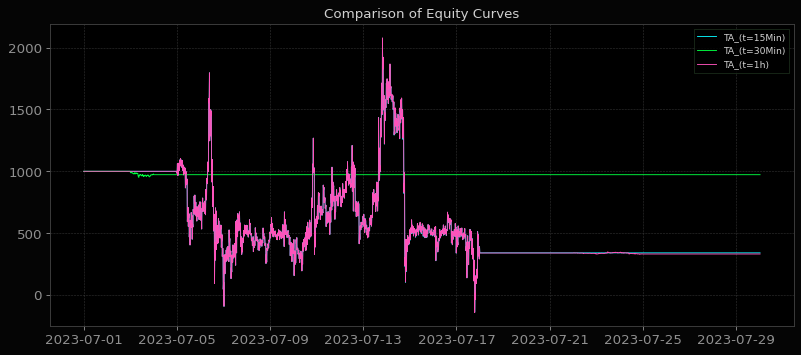

In [4]:
tearsheet(r, False, use_plotly=False)

In [5]:
r[2].config()

"TestA(timeframe='1h', exchange='BINANCE.UM')"

In [ ]:
# chart_signals(r[0], 'BTCUSDT', ld[['BTCUSDT']], show_signals=True)

## <font color='#00ff00'>-> New approach</font>

In [ ]:
# - real data from CSV
l1 = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)

# - 'real' quotes provider
rnd = lambda n: np.random.randn(n)  # noqa: E731
idx = pd.date_range(start="2023-06-01 00:00", end="2023-07-30", freq="1h", name="timestamp")
q_data = pd.DataFrame({"bid": rnd(len(idx)), "ask": rnd(len(idx)), "bid_vol": rnd(len(idx)), "ask_vol": rnd(len(idx)) }, index=idx)
qts_reader = InMemoryDataFrameReader({"BINANCE.UM:BTCUSDT": q_data})

# - any data provider
idx = pd.date_range(start="2023-06-01 00:00", end="2023-07-30", freq="1h", name="timestamp")
c_data = pd.DataFrame({"value1": rnd(len(idx)), "value2": rnd(len(idx))}, index=idx)
custom_reader = InMemoryDataFrameReader({"BINANCE.UM:BTCUSDT": c_data})

In [70]:
class TestB(IStrategy):
    ma_period: str = "15Min"
    apply_own_schedule = False
    show_mkt = False

    def on_init(self, ctx: IStrategyContext):
        if self.apply_own_schedule: ctx.set_event_schedule("0 */1 * * *")

    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent) -> list[Signal] | Signal | None:
        if self.show_mkt:
            logger.info(f'{data.instrument.symbol} market event ::: <g>{data.type}</g>\t:::  -> {data.data}')

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal] | None:
        s = []
        if 0:
            logger.info('<r> === Event ===</r>')
            return s

        for i in ctx.instruments:
            data = ctx.ohlc(i, self.ma_period, 100)
            # logger.info(data)
            s1 = ta.kama(data.close, 6) - ta.kama(data.close, 3)
            if len(s1) > 1:
                if s1[1] < 0 and s1[0] > 0:
                    logger.info(f" >> BUY: {i}")
                    s.append(i.signal(+1))

                if s1[1] > 0 and s1[0] < 0:
                    logger.info(f"SELL: {i}")
                    s.append(i.signal(-1))
        return s

In [91]:
CFGS = [

   l1,                                     # 0 - just reader

   l1[['BTCUSDT'], "2023-06-01":"now"],    # 1 - as dict with dataframes

   {'ohlc': l1},                           # 2 - as specified ohlc

   {'ohlc(4h)': l1},                       # 3 - as 4h - we want to get triggers on 4h bars close

   {'ohlc(6h)': l1[['BTCUSDT']] },         # 4 - as 6h from predefined data

   {                                       # 5 - ohlc + real quotes / trades + custom data
      'ohlc(12h)': l1,                     
      'trade': l1, 
      'quote': l1, 
      '<y>quote1</y>': qts_reader, 
      '<r>MY_DATA</r>': custom_reader
    },
]

r = simulate({'A': TestB(show_mkt=0, apply_own_schedule=0, ma_period="1h")}, 

   CFGS[0],

   1000, ['BINANCE.UM:BTCUSDT', 'BINANCE.UM:ETHUSDT'], 
   # 1000, ['BINANCE.UM:ETHUSDT'], 
   "vip0_usdt", "2023-07-01", "2023-07-03", debug="DEBUG",
   enable_event_batching=False
)

2024-12-18 10:14:14.495 [ 🐞 ] (simulator) 2023-07-01 00:00:00 Initiating simulated trading for binance.um for 1000 x 1.0 in USDT...
2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider.binance.um is initialized
2023-07-01 00:00:00.000 [🐞]  | Setting up default base subscription: ohlc(1h)
2023-07-01 00:00:00.000 [🐞]  | Setting default schedule: 0 */1 * * *
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments __all__ -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscriptions None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(1h) -> []


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(1h) -> []
2023-07-01 00:00:00.000 [🐞]  | subscribe: ohlc(1h) -> {BINANCE.UM:SWAP:BTCUSDT, BINANCE.UM:SWAP:ETHUSDT}
2023-07-01 00:00:00.000 [ℹ️] SimulatedDataProvider ::: Simulation started at 2023-07-01 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.1h 2023-07-01 00:00:00 : 2023-07-03 00:00:00 ...
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.1h 2023-07-01 00:00:00 : 2023-07-03 00:00:00 ...
2023-07-01 00:59:59.000 [🐞] Invoking TestB on_fit
2023-07-01 00:59:59.000 [🐞] TestB is fitted
2023-07-01 07:00:01.000 [ℹ️] SELL: BINANCE.UM:SWAP:BTCUSDT
2023-07-01 07:00:01.000 [🐞] (StrategyContext) sending market sell for 1.0 of BTCUSDT @ None ...
2023-07-01 07:00:01.000 [🐞] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100001 MARKET SELL 1.0 executed at 30441.45
2023-07-01 07:00:01.000 [🐞] [BINANCE.UM:SWAP:BTCUSDT] [SIM-ORDER-BTCUSDT-100001] Order

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
A,-150.866,-1.0,-3.974,-0.188,50.178,590.91,-7.449,-7.012,0.939,0.007,303.094,-4.065,151.591,13.0


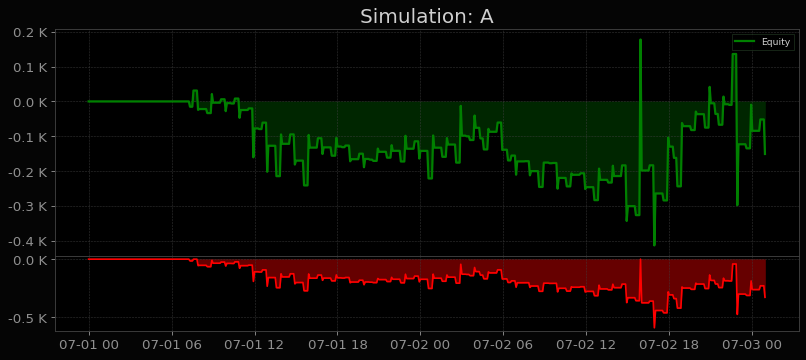

In [92]:
tearsheet(r, False)

In [93]:
r[0].executions_log

,instrument_id,exchange_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,,
2023-07-01 07:00:01,BTCUSDT,BINANCE.UM,sell,-1.0,30441.450,15.220725,USDT
2023-07-01 10:00:01,ETHUSDT,BINANCE.UM,buy,1.0,1916.145,0.958073,USDT
2023-07-01 12:00:01,ETHUSDT,BINANCE.UM,sell,-2.0,1921.975,1.921975,USDT
2023-07-01 18:00:01,ETHUSDT,BINANCE.UM,buy,2.0,1918.015,1.918015,USDT
2023-07-01 20:00:01,ETHUSDT,BINANCE.UM,sell,-2.0,1922.235,1.922235,USDT
2023-07-02 03:00:01,ETHUSDT,BINANCE.UM,buy,2.0,1918.975,1.918975,USDT
2023-07-02 04:00:01,BTCUSDT,BINANCE.UM,buy,2.0,30505.250,30.505250,USDT
2023-07-02 06:00:01,BTCUSDT,BINANCE.UM,sell,-2.0,30473.050,30.473050,USDT
2023-07-02 09:00:01,ETHUSDT,BINANCE.UM,sell,-2.0,1911.265,1.911265,USDT


In [ ]:
chart_signals(r[0], 'BTCUSDT', l15[['BTCUSDT']], show_signals=True, show_trades=True)

### Data Recognition (Experiments)

----

In [38]:
# - db/csv readers
l1 = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)
l2 = loader("BINANCE.UM", "1Min", source="mqdb::nebula")
l3 = loader("BINANCE.UM", "1d", source="csv::../tests/data/csv_1h", n_jobs=1)

# - any custom data
idx = pd.date_range(start="2023-06-01 00:00", end="2023-07-30", freq="1h", name="timestamp")
c_data = pd.DataFrame({"value1": np.random.randn(len(idx)), "value2": np.random.randn(len(idx))}, index=idx)
custom_reader = InMemoryDataFrameReader({"BINANCE.UM:BTCUSDT": c_data})

# - quotes
idx = pd.date_range(start="2023-06-01 00:00", end="2023-07-30", freq="1h", name="timestamp")
q_data = pd.DataFrame({"bid": np.random.randn(len(idx)), "ask": np.random.randn(len(idx))}, index=idx)
qts_r = InMemoryDataFrameReader({"BINANCE.UM:BTCUSDT": q_data})

In [42]:
from qubx.backtester.utils import recognize_simulation_data_config

instrs = [lookup.find_symbol("BINANCE.UM", s) for s in ["BTCUSDT", "BCHUSDT", "LTCUSDT"]]  # type: ignore
recognize_simulation_data_config(
    # ld[['BTCUSDT', 'ETHUSDT'], "2023-06-01":"2023-07-30"], # 1 - just from ohlc frames
    # ld, # 2 - from reader
    {
        "ohlc(15min)": l1,
        # "ohlc(1d)": ld,
        # "ohlc": ld,
        # "ohlc(1Min)": qts_r,
        # "ohlc(1d)": l1,
        # "ohlc": l1[['BTCUSDT', 'ETHUSDT'], "2023-06-01":"2023-07-30"],
        # "quote": qts_r,
        # "quote": ld,
        # "trade": l1,
        "custom": custom_reader,
    },
    instrs, "BINANCE.UM")

('0 */1 * * *',
 'ohlc(1h)',
 {ohlc: <qubx.data.helpers.InMemoryCachedReader at 0x1d2ef592e10>,
  'custom': <qubx.data.readers.InMemoryDataFrameReader at 0x1d2ef716490>})

In [34]:
['a'] + [1,2,3]

['a', 1, 2, 3]

In [ ]:
# timedelta_to_crontab(pd.Timedelta("1d23h55Min"))